# Load the Dataset

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from helper import get_class_names, get_train_data, get_test_data, plot_images, plot_model

# helper module to download the cifar 10 dataset
import cifar10
#print tensorflow version
tf.__version__

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'1.4.0-dev20170920'

Set the path, where the dataset will be stored

In [2]:
cifar10.data_path = "/home/soeren/Documents/Github/CIFAR-10/data"
#change the style of matplotlib plots
matplotlib.style.use('ggplot')
# set train to 1 if you want to train a new model or 0 if you just want to load an already existing set of weights
train = 0

Download and extract the data automatically, if it has not already been downloaded

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/batches.meta


[u'airplane',
 u'automobile',
 u'bird',
 u'cat',
 u'deer',
 u'dog',
 u'frog',
 u'horse',
 u'ship',
 u'truck']

Load the training-set.

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_1
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_2
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_3
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_4
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_5


In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()
print("Size of:")
print("-  Trainning-set:\t{}".format(len(images_train)))
print("-  Test-set:\t\t{}".format(len(images_test)))

Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/test_batch
Size of:
-  Trainning-set:	50000
-  Test-set:		10000


# Helperfunctions

First we have to import the data dimensions. They have already been defined in the cifar 10 module 

In [7]:
from cifar10 import img_size, num_channels, num_classes

Image size is originally 32x32 but we will corp them to 24x24

In [8]:
img_size_cropped = 24

### Plot 3x3 images

In [9]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

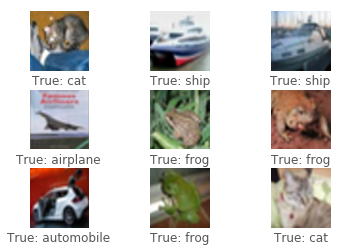

In [10]:
# Get the first images from test-set
images = images_test[0:9]

# Get the true classes from those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

# Create the CNN 

In [11]:
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size,img_size,num_channels)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    return model

In [12]:
model = cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

#  Define Training

## Save the model

In [13]:
checkpoint = ModelCheckpoint('save/cifar_10_model.h5', # model filename
                            monitor='val_loss',   # quantity to monitor
                            verbose=0,            # verbosity - 0 or 1
                            save_best_only=True,  # The latest best model will not be overwritten
                            mode='auto')         # The decision to overwrite model is made
                                                  # automatically depending on the quantity to monitor

## Define the optimization

In [14]:
model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=1.0e-4),       # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy'])          # Metrics to be evaluated by the model

## Start Training

In [15]:
if train:
    model_details = model.fit(images_train, labels_train,
                             batch_size = 128, 
                             epochs = 100,
                             validation_data = (images_test, labels_test),
                             callbacks=[checkpoint],
                             verbose=1)
    train = 1

# Evaluate the model

## Load already trained model

In [16]:
if train == 0:
    model.load_weights("save/cifar_10_model.h5")

In [17]:
scores = model.evaluate(images_test,labels_test,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 78.14%


In [38]:
if train:
    # only works if training is applied
    plot_model(model_details)

# Show misclassified results

In [19]:
class_pred = model.predict(images_test, batch_size=32)
print(class_pred[0])

[5.2012565e-05 2.1348309e-04 3.5938196e-04 5.5404282e-01 2.4640047e-05
 4.4265744e-01 1.9787990e-03 2.0992193e-04 4.5079261e-04 1.0702164e-05]


In [20]:
labels_pred = np.argmax(class_pred,axis = 1)
print(labels_pred)

[3 8 8 ... 5 4 7]


In [21]:
correct = (labels_pred == cls_test)
print(correct)
print("Nr. of correct predictions: {}".format(sum(correct)))

[ True  True  True ...  True False  True]
Nr. of correct predictions: 7814


In [22]:
incorrect = (correct == False)

images_error = images_test[incorrect]
labels_error = labels_pred[incorrect]
labels_true = cls_test[incorrect]
print(labels_error)
print(labels_true)

[4 4 9 ... 3 3 4]
[5 2 2 ... 5 8 1]


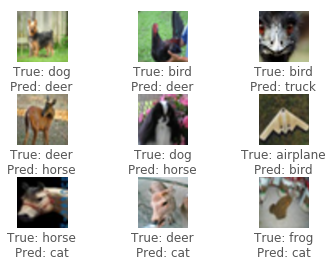

In [37]:
plot_images(images_error[0:9], labels_true[0:9],labels_error[0:9])